In [1]:
!git clone https://github.com/pondelion/algotham_v2.git

Cloning into 'algotham_v2'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 23 (delta 1), reused 20 (delta 1), pack-reused 0
Receiving objects: 100% (23/23), 4.61 MiB | 19.99 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [3]:
%cd algotham_v2

/content/algotham_v2


In [ ]:
# also can be directly installed from git
#!pip install git+https://github.com/pondelion/algotham_v2.git

In [4]:
from typing import Optional

import numpy as np
import pandas as pd

from algotham.backtest import BackTest
from algotham.order import Order
from algotham.portfolio import Portfolio
from algotham.strategy import BaseStrategy

## define custom strategy

In [5]:
class SampleStrategy(BaseStrategy):
    def next(self, dt_idx: pd.Timestamp, idx: int, bt: "BackTest"):
        print(idx, dt_idx, bt.df_ref_data["btcjpy_buy"].loc[dt_idx]["price_mean"])  # type: ignore
        if idx < 20:
            return
        # using past 20 periods feature data for prediction
        s_idx = idx + 1 - 20
        e_idx = idx + 1
        df_feat = bt.df_ref_data["btcjpy_buy"].iloc[s_idx:e_idx]  # type: ignore
        assert df_feat.index.max() == dt_idx, (
            "index mismatch",
            df_feat.index.max(),
            dt_idx,
        )
        pred = self._mock_daily_prediction(df_feat)
        if pred == 1:
            order = bt.buy(
                asset_name="BTC_JPY",
                sr_ref_price=bt.df_ref_data["btcjpy_buy"]["price_ohlc_open"],  # type: ignore
                abs_size=0.01,
                dt_idx=dt_idx,
                idx=idx,
            )
            order
            # print(order)
        elif pred == -1:
            order = bt.sell(
                asset_name="BTC_JPY",
                sr_ref_price=bt.df_ref_data["btcjpy_sell"]["price_ohlc_open"],  # type: ignore
                abs_size=0.01,
                dt_idx=dt_idx,
                idx=idx,
            )
            order
            # print(order)

    def _mock_daily_prediction(self, df_feat: pd.DataFrame) -> int:
        rnd = np.random.random()
        if rnd <= 0.4:
            return 1  # buy
        elif rnd < 0.6:
            return 0  # do nothing
        else:
            return -1  # sell

    def on_order_accepted(
        self, order: Order, bt: "BackTest", dt_idx: Optional[pd.Timestamp] = None
    ):
        print(f"[{dt_idx}] on_order_accepted {order.order_type}, {order.order_id}")

    def on_order_processed(
        self, order: Order, bt: "BackTest", dt_idx: Optional[pd.Timestamp] = None
    ):
        print(f"[{dt_idx}] on_order_processed {order.order_type}, {order.order_id}")

## prepare data

In [6]:
BTCJPY_BUY_SAMPLE_DATA_URL = "https://github.com/pondelion/algotham_v2/raw/main/data/sample/sample_btcjpy_buy_5min_230601.csv.gzip"
BTCJPY_SELL_SAMPLE_DATA_URL = "https://github.com/pondelion/algotham_v2/raw/main/data/sample/sample_btcjpy_sell_5min_230601.csv.gzip"
df_btcjpy_buy = pd.read_csv(BTCJPY_BUY_SAMPLE_DATA_URL, compression="gzip")
df_btcjpy_sell = pd.read_csv(BTCJPY_SELL_SAMPLE_DATA_URL, compression="gzip")
df_btcjpy_buy["timestamp"] = pd.to_datetime(
    df_btcjpy_buy["timestamp"], utc=True
)
df_btcjpy_sell["timestamp"] = pd.to_datetime(
    df_btcjpy_sell["timestamp"], utc=True
)
df_btcjpy_buy = df_btcjpy_buy.set_index("timestamp")
df_btcjpy_sell = df_btcjpy_sell.set_index("timestamp")
assert (df_btcjpy_buy.index == df_btcjpy_sell.index).all()

In [7]:
df_btcjpy_buy

,size_mean,size_std,size_count,size_sum,size_ohlc_open,size_ohlc_high,size_ohlc_low,size_ohlc_close,price_mean,price_std,price_count,price_sum,price_ohlc_open,price_ohlc_high,price_ohlc_low,price_ohlc_close,side
timestamp,,,,,,,,,,,,,,,,,
2023-06-01 00:00:00+00:00,0.021316,0.018624,38,0.81,0.04,0.10,0.01,0.02,3.793691e+06,982.818905,38,144160259.0,3795000.0,3795870.0,3792393.0,3793646.0,BUY
2023-06-01 00:05:00+00:00,0.041795,0.065730,39,1.63,0.08,0.30,0.01,0.01,3.795227e+06,1316.383997,39,148013837.0,3794250.0,3798190.0,3793760.0,3798165.0,BUY
2023-06-01 00:10:00+00:00,0.020732,0.020173,41,0.85,0.01,0.10,0.01,0.01,3.797244e+06,1566.893200,41,155686987.0,3798244.0,3799754.0,3795042.0,3799754.0,BUY
2023-06-01 00:15:00+00:00,0.032753,0.066662,178,5.83,0.01,0.60,0.01,0.10,3.809042e+06,3648.470246,178,678009549.0,3800000.0,3815304.0,3800000.0,3811065.0,BUY
2023-06-01 00:20:00+00:00,0.046792,0.127094,53,2.48,0.02,0.92,0.01,0.03,3.810780e+06,1484.707985,53,201971344.0,3810904.0,3813785.0,3809041.0,3809145.0,BUY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-31 20:40:00+00:00,0.010000,0.000000,8,0.08,0.01,0.01,0.01,0.01,5.243878e+06,574.102514,8,41951027.0,5243431.0,5244923.0,5243431.0,5244434.0,BUY
2023-10-31 20:45:00+00:00,0.029512,0.034853,41,1.21,0.01,0.19,0.01,0.03,5.248075e+06,2740.903236,41,215171077.0,5243297.0,5251520.0,5243297.0,5248500.0,BUY
2023-10-31 20:50:00+00:00,0.033767,0.114272,146,4.93,0.01,1.36,0.01,0.01,5.256848e+06,4039.464558,146,767499808.0,5247600.0,5263568.0,5247500.0,5258378.0,BUY


In [8]:
df_btcjpy_sell

,size_mean,size_std,size_count,size_sum,size_ohlc_open,size_ohlc_high,size_ohlc_low,size_ohlc_close,price_mean,price_std,price_count,price_sum,price_ohlc_open,price_ohlc_high,price_ohlc_low,price_ohlc_close,side
timestamp,,,,,,,,,,,,,,,,,
2023-06-01 00:00:00+00:00,0.030962,0.045299,52,1.61,0.18,0.21,0.01,0.01,3.793640e+06,1198.257262,52,197269298.0,3795322.0,3795674.0,3791414.0,3793532.0,SELL
2023-06-01 00:05:00+00:00,0.020476,0.019500,42,0.86,0.01,0.10,0.01,0.01,3.794938e+06,1633.973553,42,159387375.0,3792862.0,3797535.0,3792862.0,3796640.0,SELL
2023-06-01 00:10:00+00:00,0.027500,0.047845,24,0.66,0.03,0.24,0.01,0.24,3.796753e+06,1146.860807,24,91122076.0,3798538.0,3798809.0,3793821.0,3798809.0,SELL
2023-06-01 00:15:00+00:00,0.029680,0.037673,125,3.71,0.01,0.28,0.01,0.01,3.810195e+06,2689.775982,125,476274313.0,3800544.0,3813778.0,3800396.0,3810115.0,SELL
2023-06-01 00:20:00+00:00,0.038519,0.074312,54,2.08,0.01,0.39,0.01,0.02,3.810350e+06,1132.692863,54,205758875.0,3809741.0,3812630.0,3808353.0,3808354.0,SELL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-31 20:40:00+00:00,0.022778,0.020236,18,0.41,0.01,0.09,0.01,0.09,5.241730e+06,832.985435,18,94351149.0,5244446.0,5244446.0,5241085.0,5241085.0,SELL
2023-10-31 20:45:00+00:00,0.022553,0.019833,47,1.06,0.01,0.09,0.01,0.09,5.245329e+06,3051.236704,47,246530442.0,5241351.0,5248401.0,5241085.0,5247200.0,SELL
2023-10-31 20:50:00+00:00,0.028142,0.089168,113,3.18,0.01,0.95,0.01,0.01,5.257143e+06,2728.215978,113,594057172.0,5248770.0,5260210.0,5248003.0,5255801.0,SELL


## init portofolio

In [9]:
pf = Portfolio(init_cash=1000 * 10000)

## run backtest

In [10]:
N_PERIODS = 500  # simulate only latest 500 data

In [11]:
bt = BackTest(
    dt_index=df_btcjpy_buy[-N_PERIODS:].index,  # type: ignore
    strategy=SampleStrategy(),
    init_portfolio=pf,
    df_ref_data={
        "btcjpy_buy": df_btcjpy_buy[-N_PERIODS:],
        "btcjpy_sell": df_btcjpy_sell[-N_PERIODS:],
    },  # optional. if you want to access data from strategy via function param bt.df_ref_data, specify like this.
)

In [12]:
bt.run()

0 2023-10-30 03:25:00+00:00 5135039.352941177
1 2023-10-30 03:30:00+00:00 5135383.761904762
2 2023-10-30 03:35:00+00:00 5134739.625
3 2023-10-30 03:40:00+00:00 5136801.0
4 2023-10-30 03:45:00+00:00 5137357.666666667
5 2023-10-30 03:50:00+00:00 5138645.476190476
6 2023-10-30 03:55:00+00:00 5137683.0
7 2023-10-30 04:00:00+00:00 5137419.0
8 2023-10-30 04:05:00+00:00 5132217.0
9 2023-10-30 04:10:00+00:00 5136596.142857143
10 2023-10-30 04:15:00+00:00 5140932.609375
11 2023-10-30 04:20:00+00:00 5143900.547619048
12 2023-10-30 04:25:00+00:00 5144405.75
13 2023-10-30 04:30:00+00:00 5144078.166666667
14 2023-10-30 04:35:00+00:00 5143587.25
15 2023-10-30 04:40:00+00:00 5146035.0
16 2023-10-30 04:45:00+00:00 5147303.454545454
17 2023-10-30 04:50:00+00:00 5147995.2
18 2023-10-30 04:55:00+00:00 5146942.5
19 2023-10-30 05:00:00+00:00 5146825.666666667
20 2023-10-30 05:05:00+00:00 5145252.5
[2023-10-30 05:05:00+00:00] on_order_accepted OrderType.BUY, 9a5aea25-9314-427f-af1d-df858c551226
21 2023-10-3

## asset history

In [13]:
df_evaluated_assets_hitory = pf.evaluated_assets_hitory(
    ref_prices={"BTC_JPY": df_btcjpy_sell["price_mean"]}
)

In [14]:
df_evaluated_assets_hitory

,cash,BTC_JPY,evaluated_cash_BTC_JPY,total_evaluated_cash,pnl
datetime,,,,,
2023-10-30 03:25:00+00:00,10000000.00,0.00,0.000000,1.000000e+07,0.000000
2023-10-30 03:30:00+00:00,10000000.00,0.00,0.000000,1.000000e+07,0.000000
2023-10-30 03:35:00+00:00,10000000.00,0.00,0.000000,1.000000e+07,0.000000
2023-10-30 03:40:00+00:00,10000000.00,0.00,0.000000,1.000000e+07,0.000000
2023-10-30 03:45:00+00:00,10000000.00,0.00,0.000000,1.000000e+07,0.000000
...,...,...,...,...,...
2023-10-31 20:40:00+00:00,10045199.81,-0.01,-52417.305000,9.992783e+06,-7217.495000
2023-10-31 20:45:00+00:00,10045199.81,-0.01,-52453.285532,9.992747e+06,-7253.475532
2023-10-31 20:50:00+00:00,10097687.51,-0.02,-105142.862301,9.992545e+06,-7455.352301


<Axes: xlabel='datetime'>

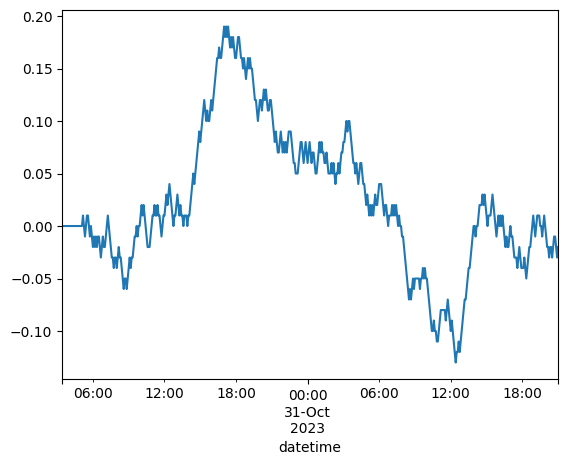

In [16]:
df_evaluated_assets_hitory['BTC_JPY'].plot()

<Axes: xlabel='datetime'>

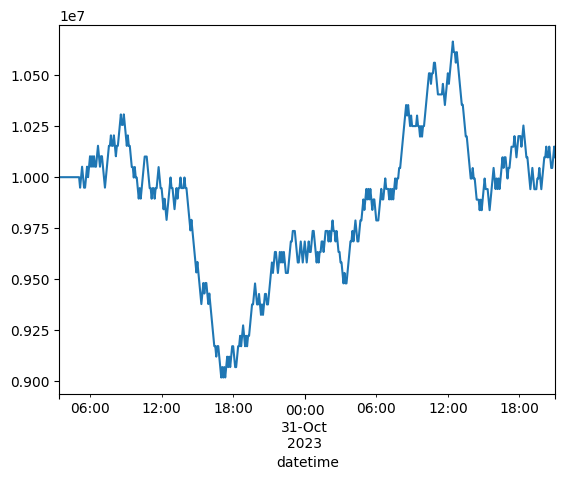

In [17]:
df_evaluated_assets_hitory['cash'].plot()

<Axes: xlabel='datetime'>

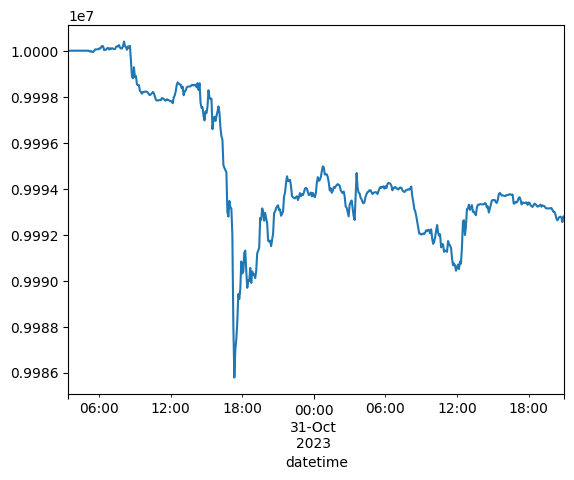

In [20]:
df_evaluated_assets_hitory['total_evaluated_cash'].plot()

<Axes: xlabel='datetime'>

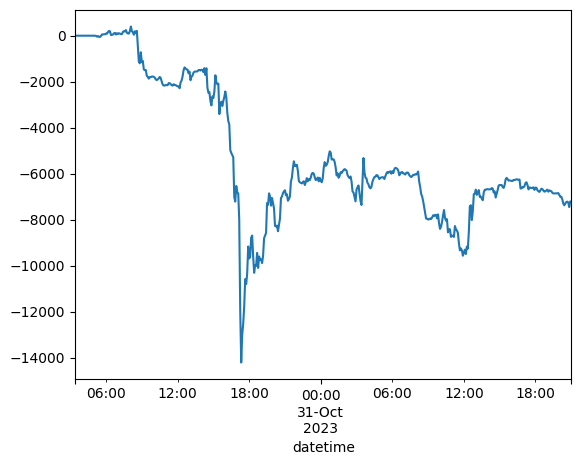

In [15]:
df_evaluated_assets_hitory['pnl'].plot()  # total profit/loss

## order history

In [18]:
df_order_history = bt.order_history

In [19]:
df_order_history

,order_type,asset_name,abs_size,ordered_timestamp,price_at_ordertime,execution_timestamp,executed_timestamp,executed_price,executed_size,status,order_id
0,OrderType.BUY,BTC_JPY,0.01,2023-10-30 05:05:00+00:00,5144000.0,2023-10-30 05:10:00+00:00,2023-10-30 05:10:00+00:00,5149125.0,0.01,OrderStatus.PROCESSED,9a5aea25-9314-427f-af1d-df858c551226
1,OrderType.SELL,BTC_JPY,0.01,2023-10-30 05:10:00+00:00,5148026.0,2023-10-30 05:15:00+00:00,2023-10-30 05:15:00+00:00,5145186.0,0.01,OrderStatus.PROCESSED,007795be-6cd6-43b3-a2c6-071e07709a18
2,OrderType.SELL,BTC_JPY,0.01,2023-10-30 05:15:00+00:00,5145186.0,2023-10-30 05:20:00+00:00,2023-10-30 05:20:00+00:00,5142754.0,0.01,OrderStatus.PROCESSED,ee761eed-d0a0-4096-9d47-a8738edd6e7e
3,OrderType.BUY,BTC_JPY,0.01,2023-10-30 05:20:00+00:00,5144922.0,2023-10-30 05:25:00+00:00,2023-10-30 05:25:00+00:00,5143799.0,0.01,OrderStatus.PROCESSED,0b51dc0e-3ce5-48d9-8215-0a2d2b565193
4,OrderType.BUY,BTC_JPY,0.01,2023-10-30 05:25:00+00:00,5143799.0,2023-10-30 05:30:00+00:00,2023-10-30 05:30:00+00:00,5137066.0,0.01,OrderStatus.PROCESSED,3de6a8e6-2a7b-4c0a-9929-f93a71de3973
...,...,...,...,...,...,...,...,...,...,...,...
380,OrderType.BUY,BTC_JPY,0.01,2023-10-31 20:35:00+00:00,5241842.0,2023-10-31 20:40:00+00:00,2023-10-31 20:40:00+00:00,5243431.0,0.01,OrderStatus.PROCESSED,990d7590-af98-4f7f-90ac-e6f0d20cdfe4
381,OrderType.SELL,BTC_JPY,0.01,2023-10-31 20:45:00+00:00,5241351.0,2023-10-31 20:50:00+00:00,2023-10-31 20:50:00+00:00,5248770.0,0.01,OrderStatus.PROCESSED,3a52211a-4408-4500-942d-796fe621d71b
382,OrderType.SELL,BTC_JPY,0.01,2023-10-31 20:50:00+00:00,5248770.0,2023-10-31 20:55:00+00:00,2023-10-31 20:55:00+00:00,5255208.0,0.01,OrderStatus.PROCESSED,cd3fbc4b-e939-40fa-9302-32a36584f9f4
383,OrderType.BUY,BTC_JPY,0.01,2023-10-31 20:55:00+00:00,5257987.0,2023-10-31 21:00:00+00:00,2023-10-31 21:00:00+00:00,5245073.0,0.01,OrderStatus.PROCESSED,2c08eb77-6c2d-4a9b-91b1-572039c68646
